## Gage Location workbook

gage data api = https://labs.waterdata.usgs.gov/api/nldi/linked-data/nwissite/USGS-07377782/basin
query gages https://waterservices.usgs.gov/nwis/iv/?sites=07377782&parameterCd=00060&period=P7D&siteStatus=all&format=json

gage location https://labs.waterdata.usgs.gov/api/observations/collections/monitoring-locations/items/USGS-07377782?f=json

flow line https://labs.waterdata.usgs.gov/api/nldi/linked-data/nwissite/USGS-07377782/navigation/UM/flowlines?distance=322

In [1]:
import sys
import os
import pathlib as pl
sys.path.append('..')
home = pl.Path(os.getcwd())

In [2]:
from src.core import *
from src.modules.curve_number.utils_CN import *

## Get rain gages within HUC basin

In [26]:
#user defined
huc12 = '030902061500'
stormwater_capacity = 5.8 #inches
if not os.path.exists(home/'Outputs'/huc12):
    os.makedirs(home/'Outputs'/huc12)
#write to txt file for later notebooks
with open(home/'Inputs'/'huc12.txt','w') as tfile:
    tfile.write(huc12)
input_dir = home/'Inputs'/huc12
if not os.path.exists(input_dir):
    os.makedirs(input_dir)

### check for gage within huc12

In [4]:
hucs_gdf = get_huc_12_gdf_from_bigger_huc(huc12)
bounds = get_huc_12_bounds(huc12)

obtaining huc12 basin information
obtaining huc12 basin information


In [5]:
site_gdf = gpd.read_file(input_dir/'site.shp')

## Get list of nearest rain gages within stream gage drainage basin

In [6]:
#get bounding box of basin
bounds = bbox_gdf(site_gdf)

In [7]:
search = 10
sr = hucs_gdf.crs.to_epsg()
rain_gage_gdf = gdf_of_local_precip_gages(bounds,sr,search)

No gages nearby at 10 meter search distance


### check for gage within a search distance if not within huc12

In [8]:
#search distance
distancez_increment = 1000 #meters
search+=distancez_increment
rain_gage_gdf = gdf_of_local_precip_gages(bounds,sr,search)


Found gages nearby


### Plot results for visuals and pertinent gage table information

In [9]:
rain_gage_gdf = add_to_gage(rain_gage_gdf)

In [10]:
rain_gage_gdf.loc[rain_gage_gdf['link_works']=='no'][['STATION_ID','STATION_NAME','DATA_BEGIN_DATE','DATA_END_DATE','Period of Record']].sort_values('Period of Record',ascending=False)

,STATION_ID,STATION_NAME,DATA_BEGIN_DATE,DATA_END_DATE,Period of Record


In [11]:
rain_gage_gdf.loc[rain_gage_gdf['link_works']=='yes'][['STATION_ID','STATION_NAME','DATA_BEGIN_DATE','DATA_END_DATE','Period of Record']].sort_values('Period of Record',ascending=False)

,STATION_ID,STATION_NAME,DATA_BEGIN_DATE,DATA_END_DATE,Period of Record
0,GHCND:USW00012839,"MIAMI INTERNATIONAL AIRPORT, FL US",1948-01-01,2023-03-27,75.233402


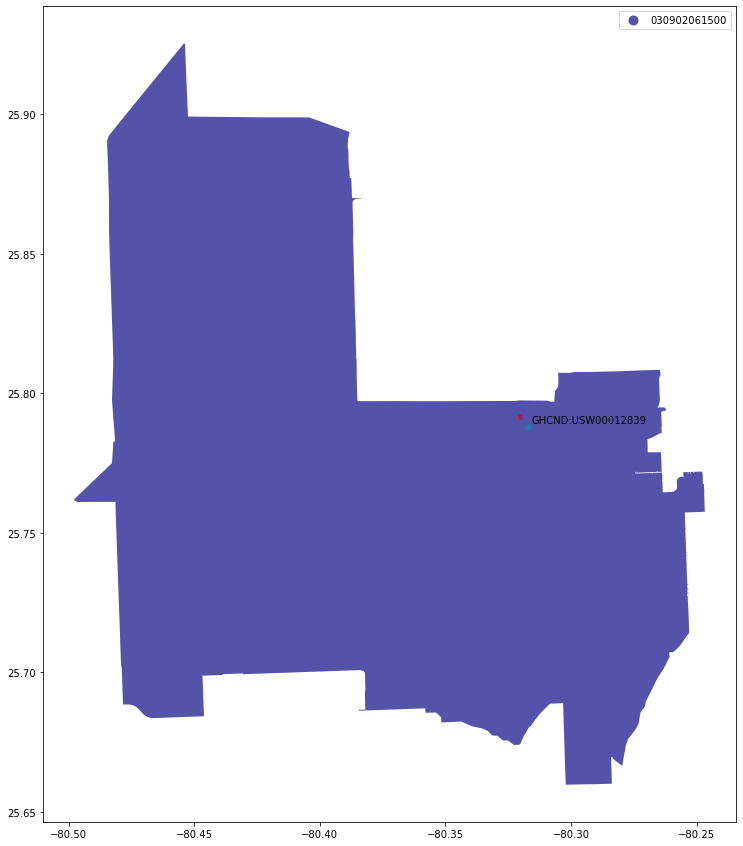

In [12]:
#from matplotlib_scalebar.scalebar import ScaleBar
fig, ax = plt.subplots(figsize=(15, 15))
hucs_gdf.plot(ax=ax, alpha=0.7, cmap="plasma",cax=f'huc{len(huc12)}',column=f'huc{len(huc12)}',legend=True)
site_gdf.boundary.plot(ax=ax,color='red')
rain_gage_gdf.plot(ax=ax)
for x, y, label in zip(rain_gage_gdf.geometry.x, rain_gage_gdf.geometry.y, rain_gage_gdf.STATION_ID):
    ax.annotate(label, xy=(x, y), xytext=(3, 3), textcoords="offset points")
    # ax.add_artist(ScaleBar(1))

In [13]:
#user selected
rain_site = 'USW00012839'
#write gage # to txt file for later notebooks
with open(home/'Inputs'/'rain_gage.txt','w') as tfile:
    tfile.write(rain_site)

In [14]:
#distance
#meters to miles
conversion = (1/1609.34)
s = rain_gage_gdf.to_crs(epsg=5070).loc[rain_gage_gdf.to_crs(epsg=5070)['STATION_ID'] == f'GHCND:{rain_site}'].centroid.iloc[0]
g = site_gdf.to_crs(epsg=5070).centroid[0]
dist = np.sqrt(np.power(s.x-g.x,2)+np.power(s.y-g.y,2))*conversion
print(f'rain gage is about {np.round(dist,2)} miles from the site') 

rain gage is about 0.31 miles from the site


In [15]:
url = f"https://www.ncei.noaa.gov/data/global-historical-climatology-network-daily/access/{rain_site}.csv"

In [17]:
csv = download_file(url,home/'Outputs')

In [18]:
daily_prcp = pd.read_csv(csv)
daily_prcp['PRCP_in'] = daily_prcp['PRCP']/(10*25.4)
daily_prcp['date_pd'] = daily_prcp['DATE'].apply(lambda x: pd.to_datetime(x))
daily_prcp.set_index('date_pd',inplace=True)

In [19]:
daily_prcp['year'] = daily_prcp['DATE'].apply(lambda x: x[:4])

In [20]:
annual_extreme = pd.DataFrame(daily_prcp.groupby('year')['PRCP_in'].max())

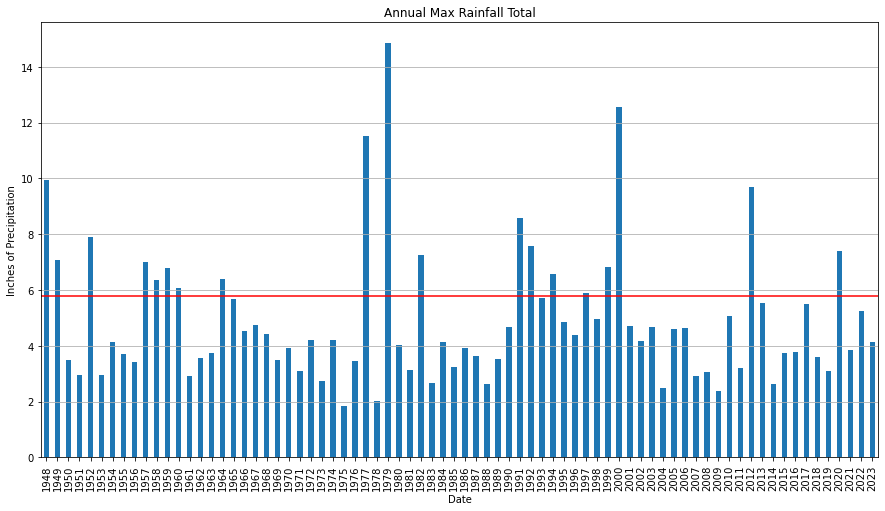

In [34]:
fig, ax = plt.subplots(figsize=(15, 8))

plt.axhline(y=stormwater_capacity, color='r', linestyle='-')
annual_extreme.plot.bar(ax=ax,title='Annual Max Rainfall Total',xlabel='Date', ylabel='Inches of Precipitation',legend=False)
ax.grid(axis='y',linestyle='-')